<a href="https://colab.research.google.com/github/fabian017/Simulacion-Digital-B1/blob/main/Parcial_2_simulacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Librerias Para el desarrollo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import random as rd
from random import random
from math import log
from google.colab import data_table
data_table.enable_dataframe_formatter()

##Punto 1

In [ ]:
def prioridad_normal(lmbda: list, TiempoServicio: int) -> list:

  #Se calcula la siguiente llegada y servicio del primer usuario

  expRandomLlegada = round(-(1/lmbda[0])*log(random()), 0)
  expRandomCajero = round(-(1/lmbda[1])*log(random()), 0)
  randomPrioridad = 1 if random() < 0.40 else 0
  columns = ['Llegada de usuario','En servicio','Prioridad asignada al usuario',
             'Tiempo acumulado','Salida','En espera','Cajero en espera','Total usuario']

  Time_series = pd.DataFrame(columns=columns)

  linea = [expRandomLlegada,expRandomCajero,randomPrioridad,
           expRandomLlegada,expRandomLlegada + expRandomCajero,0.00,expRandomLlegada,expRandomCajero]

  Time_series.loc[0] = linea

  usuarioSaleCajero = linea[4]

  k = 0

  while usuarioSaleCajero < TiempoServicio:
    
    # Último usuario
    UltimoUsuario = Time_series.iloc[-1]
    prioridaUltimoUsuario = UltimoUsuario[2]
    llegadaUltimoUsuario = UltimoUsuario[3]
    salidaUltimoUsuario = UltimoUsuario[4]

    # Siguiente llegada y servicio de un usuario
    allegadaUsuario = round(-(1/lmbda[0])*log(random()), 0)
    usuarioEnCajero = round(-(1/lmbda[1])*log(random()), 0)
    prioridadUsuario = 1 if random() < 0.40 else 0

    # Llegada y salida de un usuario
    llegadaUsuario = llegadaUltimoUsuario + allegadaUsuario
    usuarioSaleCajero = salidaUltimoUsuario + usuarioEnCajero

    # Se calculan los tiempos de espera
    if (llegadaUsuario > salidaUltimoUsuario):
      
      # Cajero inactivo
      usuarioEsperaCajero = 0
      cajeroEsperaUsuario = llegadaUsuario - salidaUltimoUsuario
      usuarioSaleCajero += cajeroEsperaUsuario
      TotalUsuario = usuarioEnCajero
    else:
      # Cajero ocupado
      cajeroEsperaUsuario = 0
      usuarioEsperaCajero = salidaUltimoUsuario - llegadaUsuario # tiempo de espera del usuario en cola
      TotalUsuario = usuarioEsperaCajero + usuarioEnCajero

    linea = [allegadaUsuario,usuarioEnCajero,prioridadUsuario,
             llegadaUsuario,usuarioSaleCajero,usuarioEsperaCajero,cajeroEsperaUsuario,TotalUsuario]
    
    k += 1
    
    Time_series.loc[k] = linea

  print(len(Time_series))
  
  ## Ahora se recalculan los tiempos de los usuarios que esperaron
  
  i = 0
  rangosOrdenados = []
  while i < len(Time_series):
    
    if Time_series.iloc[i][5] != 0:

      UltimoUsuario = Time_series.iloc[i-1]

      # Tiempo de salida del usuario que marca la espera de otros usuarios
      llegadaUltimoUsuario = UltimoUsuario[3] 

      # Tiempo de llegada del usuario que marca la espera de otros usuarios
      salidaUltimoUsuario = UltimoUsuario[4]  
      
      # Ususarios en espera desde el último en salir del cajero hasta la última llegada antes de salir
      ultimaLlegadas = Time_series.loc[(Time_series["Tiempo acumulado"] <= salidaUltimoUsuario) & (Time_series["Tiempo acumulado"] > llegadaUltimoUsuario)]
      
      
      if len(ultimaLlegadas) > 1 :

        # Ordenamos usuarios en espera por prioridad
        ultimaLlegadaOrdenada = ultimaLlegadas.sort_values(by=['Prioridad asignada al usuario'], ascending=False)
        indexes = np.array(ultimaLlegadaOrdenada.index)
        new_i = len(ultimaLlegadas)
        
        if(np.array_equal(indexes, np.array(range(min(indexes), max(indexes)+1)))):
          # Si están ordenados con antelación pasar a la siguiente iteración
          i += new_i
          continue
        rangosOrdenados.append(indexes)
        
        new_i = len(ultimaLlegadas)
        
        # Se recorre ususarios en espera y se calcula el orden
        for j in ultimaLlegadaOrdenada.index:
            
          # Calculo de nuevos tiempos
          usuarioActual = Time_series.iloc[j]
          usuarioSaleCajero = UltimoUsuario[4] + usuarioActual[1]
          usuarioEsperaCajero = UltimoUsuario[4] - usuarioActual[3]
          TotalUsuario = usuarioEsperaCajero + usuarioActual[1]
          
          # Actualización datos de usuario
          Time_series.loc[j,'Salida'] = usuarioSaleCajero
          Time_series.loc[j,'En espera'] = usuarioEsperaCajero
          Time_series.loc[j,'Total usuario'] = TotalUsuario

          # El usuario y la actualización de tiempos, este usuario se convierte en el último usuario en cajero en el rango dado
          UltimoUsuario = Time_series.iloc[j]
          
        i += new_i

    i = i + 1

  return Time_series, rangosOrdenados

# Servidor disponible en tiempo 
tiempoServicio = 1200

# Datos ordenados
dt, rangosOrdenados = prioridad_normal([0.2, 0.3], tiempoServicio)

# Los usuarios que esperaron están ordenados por prioridad
# esto lo vemos al ejecutar el código

dt.style.set_properties(**{'border': '1.5px solid blue',
                          'color': 'red'})

242


,Llegada de usuario,En servicio,Prioridad asignada al usuario,Tiempo acumulado,Salida,En espera,Cajero en espera,Total usuario
0,5.000000,27.000000,1.000000,5.000000,32.000000,0.000000,5.000000,27.000000
1,3.000000,4.000000,1.000000,8.000000,36.000000,24.000000,0.000000,28.000000
2,1.000000,4.000000,0.000000,9.000000,41.000000,28.000000,0.000000,32.000000
3,4.000000,3.000000,0.000000,13.000000,44.000000,28.000000,0.000000,31.000000
4,0.000000,6.000000,0.000000,13.000000,50.000000,31.000000,0.000000,37.000000
5,12.000000,2.000000,0.000000,25.000000,52.000000,25.000000,0.000000,27.000000
6,0.000000,1.000000,1.000000,25.000000,37.000000,11.000000,0.000000,12.000000
7,12.000000,2.000000,0.000000,37.000000,54.000000,15.000000,0.000000,17.000000
8,7.000000,3.000000,1.000000,44.000000,57.000000,10.000000,0.000000,13.000000
9,17.000000,0.000000,0.000000,61.000000,61.000000,0.000000,4.000000,0.000000


In [ ]:
#@title Datos ya ordenados con las salidas correctas

dt.sort_values(by=['Salida'], ascending=True).head(15).style.set_properties(**{'border': '1.5px solid blue',
                          'color': 'red'})

,Llegada de usuario,En servicio,Prioridad asignada al usuario,Tiempo acumulado,Salida,En espera,Cajero en espera,Total usuario
0,5.000000,0.000000,0.000000,5.000000,5.000000,0.000000,5.000000,0.000000
1,1.000000,8.000000,0.000000,6.000000,14.000000,0.000000,1.000000,8.000000
4,3.000000,2.000000,1.000000,13.000000,16.000000,1.000000,0.000000,3.000000
2,1.000000,2.000000,0.000000,7.000000,18.000000,9.000000,0.000000,11.000000
3,3.000000,1.000000,0.000000,10.000000,19.000000,8.000000,0.000000,9.000000
5,4.000000,4.000000,0.000000,17.000000,23.000000,2.000000,0.000000,6.000000
6,5.000000,2.000000,1.000000,22.000000,25.000000,1.000000,0.000000,3.000000
7,7.000000,4.000000,0.000000,29.000000,33.000000,0.000000,4.000000,4.000000
8,3.000000,0.000000,1.000000,32.000000,33.000000,1.000000,0.000000,1.000000
9,20.000000,0.000000,1.000000,52.000000,52.000000,0.000000,19.000000,0.000000


In [ ]:
#@title Prioridad 0 -> Sin prioridad
prioridad_0 = dt[dt['Prioridad asignada al usuario'] == 0]

print(f"Media del tiempo en espera usuario: { round(np.mean(prioridad_0['En espera'])/60,2)} horas en {tiempoServicio/60} horas.")
print(f"Media del tiempo cajero en espera de usuario: {round(np.mean(prioridad_0['Cajero en espera']),3)} minutos en {tiempoServicio/60} horas.")
print(f"Media del tiempo total de usuario: { round(np.mean(prioridad_0['Total usuario']),2)} minutos en {tiempoServicio/60} horas.")
print(f"Personas atendidas en {tiempoServicio/60} horas: {len(prioridad_0)}")
prioridad_0.head(15).style.set_properties(**{'border': '1.5px solid blue',
                          'color': 'red'})

Media del tiempo en espera usuario: 0.1 horas en 20.0 horas.
Media del tiempo cajero en espera de usuario: 1.893 minutos en 20.0 horas.
Media del tiempo total de usuario: 9.0 minutos en 20.0 horas.
Personas atendidas en 20.0 horas: 150


,Llegada de usuario,En servicio,Prioridad asignada al usuario,Tiempo acumulado,Salida,En espera,Cajero en espera,Total usuario
0,5.000000,0.000000,0.000000,5.000000,5.000000,0.000000,5.000000,0.000000
1,1.000000,8.000000,0.000000,6.000000,14.000000,0.000000,1.000000,8.000000
2,1.000000,2.000000,0.000000,7.000000,18.000000,9.000000,0.000000,11.000000
3,3.000000,1.000000,0.000000,10.000000,19.000000,8.000000,0.000000,9.000000
5,4.000000,4.000000,0.000000,17.000000,23.000000,2.000000,0.000000,6.000000
7,7.000000,4.000000,0.000000,29.000000,33.000000,0.000000,4.000000,4.000000
10,3.000000,2.000000,0.000000,55.000000,57.000000,0.000000,3.000000,2.000000
11,10.000000,12.000000,0.000000,65.000000,77.000000,0.000000,8.000000,12.000000
12,0.000000,0.000000,0.000000,65.000000,77.000000,12.000000,0.000000,12.000000
13,0.000000,10.000000,0.000000,65.000000,87.000000,12.000000,0.000000,22.000000


In [ ]:
#@title Prioridad 1 -> Con prioridad
prioridad_1 = dt[dt['Prioridad asignada al usuario'] == 1]

print(f"Media del tiempo que espera un usuario el cajero: { round(np.mean(prioridad_1['En espera'])/60,2)} horas en {tiempoServicio/60} horas.")
print(f"Media del tiempo que espera un cajero a un usuario: {round(np.mean(prioridad_1['Cajero en espera']),3)} minutos en {tiempoServicio/60} horas.")
print(f"Media del tiempo gastado por usuario: { round(np.mean(prioridad_1['Total usuario']),2)} minutos en {tiempoServicio/60} horas.")
print(f"Personas atendidas en {tiempoServicio/60} horas: {len(prioridad_1)}")
prioridad_1.head(20).style.set_properties(**{'border': '1.5px solid blue',
                          'color': 'red'})

Media del tiempo que espera un usuario el cajero: 0.08 horas en 20.0 horas.
Media del tiempo que espera un cajero a un usuario: 2.319 minutos en 20.0 horas.
Media del tiempo gastado por usuario: 7.76 minutos en 20.0 horas.
Personas atendidas en 20.0 horas: 91


,Llegada de usuario,En servicio,Prioridad asignada al usuario,Tiempo acumulado,Salida,En espera,Cajero en espera,Total usuario
4,3.000000,2.000000,1.000000,13.000000,16.000000,1.000000,0.000000,3.000000
6,5.000000,2.000000,1.000000,22.000000,25.000000,1.000000,0.000000,3.000000
8,3.000000,0.000000,1.000000,32.000000,33.000000,1.000000,0.000000,1.000000
9,20.000000,0.000000,1.000000,52.000000,52.000000,0.000000,19.000000,0.000000
17,1.000000,0.000000,1.000000,92.000000,92.000000,0.000000,0.000000,0.000000
21,4.000000,0.000000,1.000000,108.000000,108.000000,0.000000,0.000000,0.000000
24,16.000000,2.000000,1.000000,132.000000,134.000000,0.000000,14.000000,2.000000
37,18.000000,2.000000,1.000000,200.000000,202.000000,0.000000,6.000000,2.000000
39,2.000000,5.000000,1.000000,204.000000,209.000000,0.000000,1.000000,5.000000
42,2.000000,2.000000,1.000000,224.000000,229.000000,3.000000,0.000000,5.000000


##Punto 2

Punto Del Libro A

$P_{11}=P(D_{n+1}=0)+P(D_{n+1}=2)+P(D_{n+1}=4)=3/5$\
$P_{12}=P(D_{n+1}=1)+P(D_{n+1}=3)=2/5$\
$P_{21}=P(D_{n+1}=1)+P(D_{n+1}=3)=2/5$\
$P_{22}=P(D_{n+1}=0)+P(D_{n+1}=2)+P(D_{n+1}=4)=3/5$

$ P= \begin{equation}
\begin{matrix}
3/5 & 2/5\\
2/5 & 3/5
\end{matrix}
\end{equation}$

Punto Del Libro B

$\pi=\pi P$\
$\pi_{1}+\pi_{2}=1$\
$\pi_{1}=\pi_{2}=1/2$

In [ ]:
#Sistema Inventarios
from random import randint
#Se definen las variables para realizar la simulacion del sistema de inventarios de usando el enfoque de eventos discretos
Periodo = 360 ;Ne = range(1,Periodo);Zn = [0];Ci = 2;    Nf = 0;    Xn = [2];  m  = 0;    Dem = []; ped = [];  
#Mediante un For se recorrera los periodos en los que nos encontramos,se calcular unidades faltantes y finalmente se revisa la condicion para poder realizar el pedido
for i in Ne:    
  D  = randint(0,8)     
  Dem.append(D)            
  Zn.append(Ci - D)         
  if Zn[i] < 1:            
    while Zn[i] + 2*m < 1:      
      m += 1                
#Se evaluan condiciones del sistema de inventarios
  if Xn[i-1] - D < 1:       
    Xn.append(Xn[i-1]- D + 2*m) 
  else:
    Xn.append(Xn[i-1]- D)       
   #finalmente se guarda el pedido que se acaba de realizar y se reinicia                            
  Ci = Xn[i]      
  ped.append(2*m) 
  m = 0      

#se usa la funcion zip() para la iteracion paralela 
data = list(zip(Xn, Zn, Dem, ped))
df = pd.DataFrame(data, columns=['Xn', 'Zn', 'Demanda', 'Numero De Pedidos'])
df.style.set_properties(**{'border': '1.5px solid blue',
                          'color': 'red'})

,Xn,Zn,Demanda,Numero De Pedidos
0,2,0,8,8
1,2,-6,4,4
2,2,-2,2,2
3,2,0,6,6
4,2,-4,1,0
5,1,1,1,2
6,2,0,1,0
7,1,1,2,2
8,1,-1,8,8
9,1,-7,8,8


In [ ]:
#Finalmente obtenemos el costo promedio del inventario y del incumplimiento.
positives = [x for x in Zn if x >= 0]
print("Promedio Inventario ",np.mean(positives))
negatives = [abs(x) for x in Zn if x < 0]
print("Promedio Incumplimiento ", np.mean(negatives))

Promedio Inventario  0.7473684210526316
Promedio Incumplimiento  3.909433962264151


## Punto 4


In [ ]:
!pip install gif

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gif: filename=gif-3.0.0-py3-none-any.whl size=4818 sha256=63da8fa9657439039124e580ad879d554854c1bcacb0bf5481bfb4bfe1c81f73
  Stored in directory: /root/.cache/pip/wheels/21/63/09/b1e3c512d244da0a7c1d9565f09592612d04b79ccbb95146ae
Successfully built gif


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gif
from IPython.display import Image
from random import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd drive/My Drive/

Mounted at /content/drive/
/content/drive/My Drive


In [ ]:
# For plotting Gaussian contours
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def plot_gaussian_from_points(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if len(x) != len(y):
        raise ValueError("x and y must be the same size")
    if len(x) < 2:
        raise ValueError("Need more data.")
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def plot_gaussian_from_parameters(mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
	mean : array-like, shape (2, )
    	Mean vector
    cov : array-like, shape (2,2)
    	Covariance matrix
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if len(mean) != 2:
        raise ValueError("Mean vector length should be 2.")
    if (cov.shape != (2, 2)):
    	raise ValueError("Covariance should be a 2x2 matrix.")
    #checking if cov is symmetric pos semidefinite
    if(cov[0, 1] != cov[1, 0]):
        raise ValueError("Covariance should be symmetric.")
    if(cov[0, 0] < 0 or cov[0, 0]*cov[1,1] - cov[0,1]**2 < 0):
        raise ValueError("Covariance should be positive semidefinite.")

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


# from random import random

# x = np.array([random()*5 for i in range(500)])
# y = np.array([random()*5 for i in range(500)])
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# ax.scatter(x, y)
# print(plot_gaussian_from_points(x, y, ax, n_std=1, edgecolor='red'))
# #print(plot_gaussian_from_parameters(np.array([2.5, 2.5]), np.cov(x, y), ax, n_std=1, edgecolor='red'))
# plt.show()  

In [ ]:
def conditional_sampler(sampling_index, current_x, mean, cov):
    conditioned_index = 1 - sampling_index
    a = cov[sampling_index, sampling_index]
    b = cov[sampling_index, conditioned_index]
    c = cov[conditioned_index, conditioned_index]
    
    mu = mean[sampling_index] + (b * (current_x[conditioned_index] - mean[conditioned_index]))/c
    sigma = np.sqrt(a-(b**2)/c)
    new_x = np.copy(current_x)
    new_x[sampling_index] = np.random.exponential()*sigma + mu
    return new_x

In [ ]:
@gif.frame
def plot_samples(samples, num_samples, tmp_points, num_tmp, title="Gibbs Sampling", xlims=(-11, 11), ylims=(-11, 11)):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca()
    
    # Plot the true distribution
    plot_gaussian_from_parameters(mean, cov, ax, n_std=2, edgecolor='g', alpha=0.5, label="True Distribution")
    
    # Plot sampled points
    ax.scatter(samples[:num_samples, 0], samples[:num_samples, 1], c='b', s=10, label="Sampled Points")
    ax.scatter(samples[0, 0], samples[0, 1], marker='*', c='g', s=60, label="Initial Point")
    
    # Plot samples from conditional distribution
    ax.scatter(tmp_points[:num_tmp, 0], tmp_points[:num_tmp, 1], c='r', alpha=0.4, s=5, label="Temporary Points")
    
    # Keeping the axes scales same for good GIFS
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    # Plot lines
    if(num_tmp > 0):
        ax.plot([samples[num_samples-1, 0], tmp_points[num_tmp-1, 0]], 
                [samples[num_samples-1, 1], tmp_points[num_tmp-1, 1]], c='k', alpha=0.25)
        # Plot estimated Gaussian, ignoring the starting point
        if(num_samples > 2):
            plot_gaussian_from_points(samples[1:num_samples, 0], samples[1:num_samples, 1], 
                                      ax, n_std=2, edgecolor='b', alpha=0.5, label="Estimated Distribution")
    
    ax.legend(loc='upper left')
    ax.set_title(title)

In [ ]:
def gibbs_sampler(initial_point, num_samples, mean, cov, create_gif=True):

    frames = []  # for GIF
    point = np.array(initial_point)
    samples = np.empty([num_samples+1, 2])  #sampled points
    samples[0] = point
    tmp_points = np.empty([num_samples, 2]) #inbetween points

    for i in range(num_samples):

        # Sample from p(x_0|x_1)
        point = conditional_sampler(0, point, mean, cov)
        tmp_points[i] = point
        if(create_gif):
            frames.append(plot_samples(samples, i+1, tmp_points, i+1, title="Num Samples: " + str(i)))
            
        # Sample from p(x_1|x_0)
        point = conditional_sampler(1, point, mean, cov)
        samples[i+1] = point
        if(create_gif):
            frames.append(plot_samples(samples, i+2, tmp_points, i+1, title="Num Samples: " + str(i+1)))
            
    if(create_gif):
        return samples, tmp_points, frames
    else:
        return samples, tmp_points

In [ ]:
mean = np.array([0, 0])
cov = np.array([[12, 1], 
                [1, 6]])

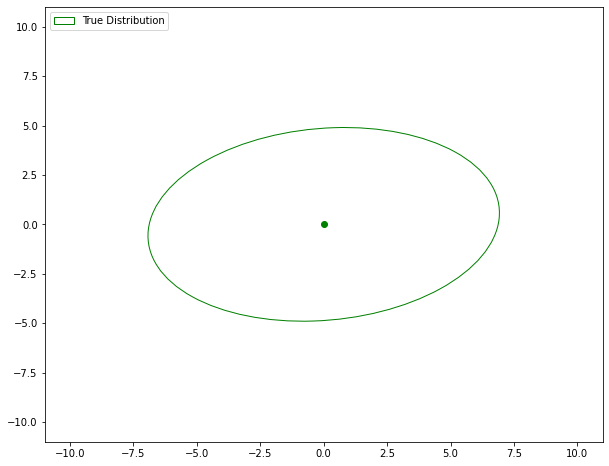

In [ ]:
# Plot true distribution
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
plot_gaussian_from_parameters(mean, cov, ax, n_std=2, edgecolor='g', label="True Distribution")
ax.scatter(mean[0], mean[1], c='g')
ax.set_xlim((-11, 11))
ax.set_ylim((-11, 11))
ax.legend(loc='upper left')
plt.show()

In [ ]:
initial_point = [-9.0, -9.0]
num_samples = 300
samples, tmp_points, frames = gibbs_sampler(initial_point, num_samples, mean, cov, create_gif=True)


In [ ]:
# Creating the GIF
from IPython.display import Image
gif.save(frames, "soto.gif", duration=250)
Image(filename="soto.gif")